In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [ ]:
class PINN(torch.nn.Module):

    def __init__(self, X_u, u, X_f):
        super(PINN, self).__init__()

        self.x_u = torch.tensor(X_u[:, 0][...,None],
                                requires_grad=True).float()
        self.t_u = torch.tensor(X_u[:, 1][...,None],
                                requires_grad=True).float()
        self.x_f = torch.tensor(X_f[:, 0][...,None],
                                requires_grad=True).float()
        self.t_f = torch.tensor(X_f[:, 1][...,None],
                                requires_grad=True).float()
        self.u = torch.tensor(u).float()

        self.net = torch.nn.Sequential(
            torch.nn.Linear(2, 16),
            torch.nn.Tanh(),
            torch.nn.Linear(16, 32),
            torch.nn.Tanh(),
            torch.nn.Linear(32, 64),
            torch.nn.Tanh(),
            torch.nn.Linear(64, 1),
        )

    def get_u(self):
      return self.u

    def net_f(self, x, t):
        u = self.net(torch.hstack((x, t)))

        u_t = torch.autograd.grad(
            u, t,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_x = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True)[0]

        u_xx = torch.autograd.grad(
            u_x, x,
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True)[0]

        nu = torch.tensor((0.01 / np.pi))

        f = u_t + (u * u_x) - (nu * u_xx)

        return f

    def forward(self):
        u_prediction = self.net(torch.hstack((self.x_u, self.t_u)))
        f_prediction = self.net_f(self.x_f, self.t_f)
        return u_prediction, f_prediction


In [ ]:
from scipy.stats.qmc import LatinHypercube
# num boundary points
N_u = 100
# collocation points
N_f = 10000

# random shuffle
index = np.arange(0, N_u)
np.random.shuffle(index)

# sample collocation by latin hypercube
engine = LatinHypercube(d=1)
sample_x = engine.random(n=N_f)
sample_x = sample_x*2-1
sample_t = engine.random(n=N_f)
X_f_train = np.concatenate((sample_x,sample_t),axis=1)

# get boundary point nums
num_top_and_bottom = 100//4
num_zero = 100//2

# get random samples on boundaries
x_zero = (np.random.rand(num_zero)*2-1)[...,None]
lower = np.hstack(((np.ones(num_top_and_bottom)*-1)[...,None], np.random.rand(num_top_and_bottom)[...,None]))
upper = np.hstack((np.ones(num_top_and_bottom)[...,None], np.random.rand(num_top_and_bottom)[...,None]))
zero = np.hstack((x_zero,np.zeros(num_zero)[...,None]))
X_u_train = np.vstack( (upper, lower, zero) )
X_u_train = X_u_train[index, :]

# combine boundary and collocation points
X_f_train = np.vstack( (X_f_train, X_u_train) )

# stack them in the same order as X_u_train was stacked
u_upper = np.zeros(num_top_and_bottom)[...,None]
u_lower = np.zeros(num_top_and_bottom)[...,None]
u_zero = -np.sin(np.pi * x_zero)
u_train = np.vstack( (u_upper, u_lower, u_zero) )

# match indices with X_u_train
u_train = u_train[index, :]

pinn = PINN(X_u_train, u_train, X_f_train)

In [ ]:
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.LBFGS(pinn.parameters(),lr=1)

n_epochs = 50

for epoch in range(n_epochs):

    # forward pass
    def closure():
      u_prediction, f_prediction = pinn()
      u_loss = loss_fn(u_prediction, pinn.get_u())
      f_loss = loss_fn(f_prediction, torch.zeros((X_f_train.shape[0], 1)))
      loss = u_loss + f_loss
      optimizer.zero_grad()
      loss.backward()
      return loss

    optimizer.step(closure)

    if epoch % 5 == 0:
        print(f"epoch: {epoch}")


epoch: 0
epoch: 5
epoch: 10
epoch: 15
epoch: 20
epoch: 25
epoch: 30
epoch: 35
epoch: 40
epoch: 45


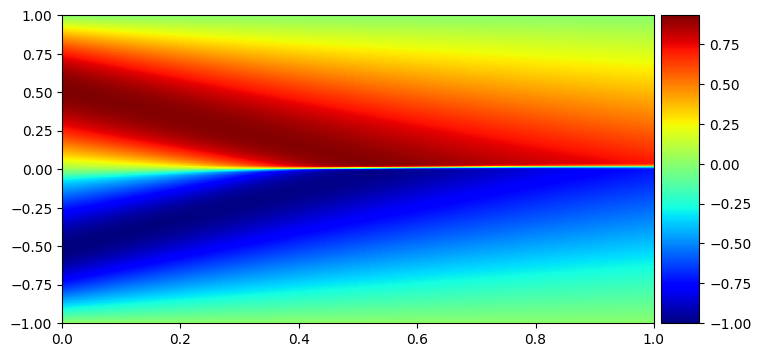

In [ ]:
plt.rcParams["figure.figsize"] = (20,4)

xcol = torch.linspace(-1, 1, 200).repeat_interleave(200)[...,None]
tcol = torch.linspace( 0, 1, 200).repeat(200)[...,None]

u_pred = pinn.net(torch.hstack((xcol, tcol))).reshape(200, 200).detach().numpy()

plt.subplot(1, 2, 2)
plt.imshow(u_pred, extent=(0,1,-1,1), cmap='jet', aspect='auto')
plt.colorbar(aspect=8, pad=0.01)
plt.show()